In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy import units as u
from astropy.table import Table
from astropy.time import Time
import lightkurve as lk
from matplotlib.collections import LineCollection
from tqdm import tqdm_notebook
import stella

import glob, os
import tensorflow as tf

from astropy.table import Table
plt.rcParams['font.size'] = 20

In [2]:
import platform,h5py
print('python',platform.python_version())
print('lightkurve',lk.__version__)
print('tf',tf.__version__)
print('stella',stella.__version__)
print('h5py',h5py.__version__)
print('astropy',astropy.__version__)

python 3.8.10
lightkurve 2.0.11.to_fits
tf 2.5.0
stella 0.0.5
h5py 2.10.0
astropy 4.3.post1


In [3]:
from scripts import *

In [4]:
models

['../data/run01/ensemble_s0038_i0350_b0.73.h5',
 '../data/run01/ensemble_s0028_i0350_b0.73.h5',
 '../data/run01/ensemble_s0050_i0350_b0.73.h5',
 '../data/run01/ensemble_s0029_i0350_b0.73.h5',
 '../data/run01/ensemble_s0078_i0350_b0.73.h5',
 '../data/run01/ensemble_s0080_i0350_b0.73.h5',
 '../data/run01/ensemble_s0077_i0350_b0.73.h5',
 '../data/run01/ensemble_s0004_i0350_b0.73.h5',
 '../data/run01/ensemble_s0005_i0350_b0.73.h5',
 '../data/run01/ensemble_s0018_i0350_b0.73.h5']

In [5]:
# targets2 = Table.read('m_dwarf_dections_27_03_20_correct_fluxes.fits')

In [5]:
targets = Table.read('../data/radio-xray-data.fits')
names = targets['common_name']


In [106]:
name = 'YY Gem' # 0.4074 d EB, 1% depth
name = 'DG CVn'
# name = '44 Boo'

radius = 10.0

In [107]:
# name = 'GJ 625'
search=lk.search_lightcurvefile(name,radius=radius,exptime=120)
# search = lk.search_lightcurvefile('TIC 335294086')
# lcs = search.download_all()

/var/folders/q3/wlh9qxyn1nxdm7v7l30qryf00000gn/T/ipykernel_55436/2892187761.py:2: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  search=lk.search_lightcurvefile(name,radius=radius,exptime=120)


In [108]:
tics, time, flux, errs, sects, data_all = load_lightcurve(name,radius=radius,from_saved=False)

/Users/benjaminpope/code/mtv/notebooks/scripts.py:117: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  search = lk.search_lightcurvefile(starname,radius=radius,exptime=120)


Downloaded lightcurve!


/Users/benjaminpope/code/mtv/notebooks/scripts.py:158: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  d = data.PDCSAP_FLUX.remove_nans().normalize()


In [109]:
period = get_rotation_period(tics,time,flux,errs)
print(period)

Finding most likely periods: 100%|████████████████| 1/1 [00:00<00:00, 17.58it/s]

0.26814514286311736


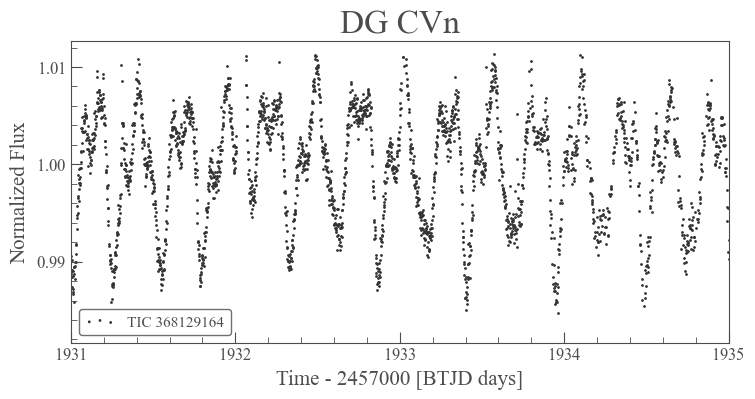

In [116]:
lc = data_all[0].normalize().remove_outliers(sigma_upper=2)
lc.scatter()
# plt.xlim(1741,1742)
plt.xlim(1931,1935)
# plt.ylim(0.95,1.05)
# t0 = 1741.15
# plt.axvline(t0)
# plt.axvline(t0+0.13386553476746763*2)
# plt.axvline(1851.05+0.4074)
plt.title(name);
plt.savefig('../results/rs_cvn/dg_cvn_zoom.png',bbox_inches='tight')

In [111]:
0.13386553476746763*2

0.26773106953493525

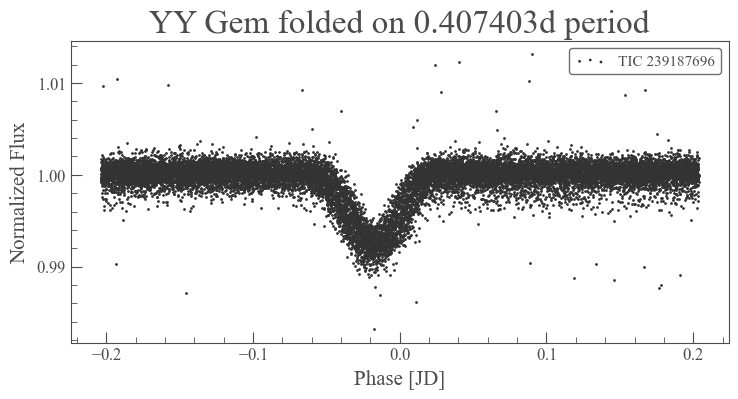

In [105]:
data_all[0].normalize().fold(0.407403).scatter()
plt.title(name+' folded on 0.407403d period');
plt.savefig('../results/rs_cvn/yy_gem_folded.png',bbox_inches='tight')

In [117]:
pgram = lc.to_periodogram()

0.26829002430653903 d


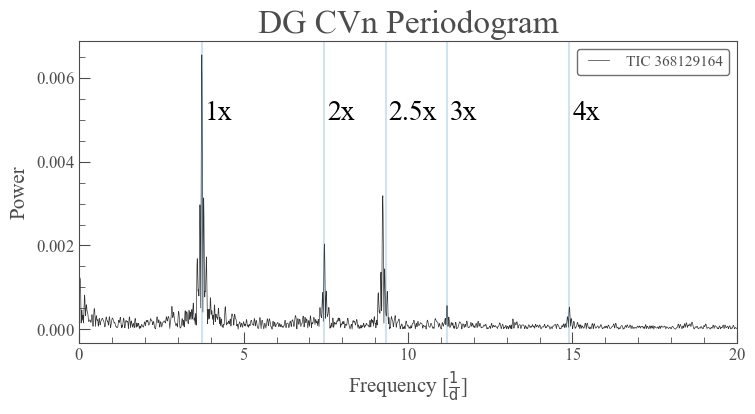

In [142]:
pgram.plot()
print(pgram.period_at_max_power)
plt.xlim(0,20)
# # plt.yscale('log')
plt.text(1/0.26829002430653903+0.1,0.005,'1x')
plt.axvline(1/0.26829002430653903,alpha=0.2)
plt.axvline(2/0.26829002430653903,alpha=0.2)

plt.text(2/0.26829002430653903+0.1,0.005,'2x')
plt.axvline(2.5/0.26829002430653903,alpha=0.2)
plt.text(2.5/0.26829002430653903+0.1,0.005,'2.5x')
plt.axvline(3/0.26829002430653903,alpha=0.2)
plt.text(3/0.26829002430653903+0.1,0.005,'3x')
plt.axvline(4/0.26829002430653903,alpha=0.2)
plt.text(4/0.26829002430653903+0.1,0.005,'4x')

plt.title(name+' Periodogram')
plt.savefig('../results/rs_cvn/dg_cvn_periodogram.png',bbox_inches='tight')

In [ ]:
avg_preds = run_cnn(tics,time,flux,errs)

In [ ]:
cnn = stella.ConvNN(output_dir='.')
preds = []

for model in models:
    cnn.predict(modelname=model,
                times=time,
                fluxes=flux,
                errs=errs)
    preds.append(cnn.predictions)
preds = np.array(preds)

avg_preds = np.copy(time)

for i in range(len(time)):
    temp = np.zeros((len(models), len(time[i])))
    for j in range(len(models)):
        temp[j] = preds[j][i]
    ap = np.nanmedian(temp, axis=0)
    avg_preds[i] = ap


In [ ]:
for j in range(preds.shape[0]):
    plt.hist(preds[j,0,:],bins=np.linspace(0,1,100))

In [ ]:
plt.hist(np.sum(preds>0.6,axis=2),bins=40); # so it looks like there are only a handful of models dominating

In [ ]:
models_bad = (np.sum(preds>0.6,axis=2)>250)[:,0]
avg_preds = np.mean(preds[:,:,:],axis=0)

In [ ]:
flare_table = get_flares(tics,time,flux,avg_preds,errs)
# flare_table.write('flares_%s.csv' % (name.replace(' ','_').lower()),format='ascii')

In [ ]:
flare_table

In [ ]:
flare_rate = get_flare_rate(time,flare_table)
print(flare_rate)

In [ ]:
groups,sectors = group_sectors(data_all)
ngroups = len(groups)
width_ratios = [len(group) for group in groups] 
fig, axes = plt.subplots(ncols=ngroups, figsize=(ngroups*7*2,4*2),
                           sharey=True, gridspec_kw={'width_ratios':width_ratios})
for j, g in enumerate(groups):
    if len(groups)>1:
        ax = axes[j]
    else:
        ax = axes
    if j == 0:
        ax.set_ylabel('Normalized Flux')
    for i in g:
        ax.scatter(time[i], flux[i], c=avg_preds[i],
                    vmin=0, vmax=1, s=6)
    if len(g)==1:
        ax.set_title('Sector '+str(sectors[g[0]]),y=1.01)
    else:
        ss = [sectors[s] for s in g]
        ax.set_title('Sectors ' + ", ".join([str(s) for s in ss]),y=1.01)
    ax.set_xlabel('TJD')
yrange = np.percentile(np.hstack(flux),(2,50,98))
lims = (yrange[1]-1.0*(yrange[2]-yrange[0]), yrange[1]+1.0*(yrange[2]-yrange[0]))
# plt.ylim(*lims)
plt.subplots_adjust(wspace=0.1)
plt.savefig('results/flare_lc_%s_nozoom.png' % (name.replace(' ','_').lower()),bbox_inches='tight')

In [ ]:
test_lc = data_all[0].normalize().remove_nans().remove_outliers()
pg = test_lc.to_periodogram(minimum_frequency=0.2,maximum_frequency=10)
pg.plot()
print('Best period:',pg.period_at_max_power.to(u.hour))
print('Best frequency:',pg.frequency_at_max_power)

In [ ]:
test_lc.fold(pg.period_at_max_power).bin(time_bin_size=0.002).scatter()

In [ ]:
do_plots(tics,time,flux,avg_preds,errs,data_all)
plt.savefig('results/flare_lc_%s.png' % (name.replace(' ','_').lower()),bbox_inches='tight')

In [ ]:
nflares = len(flare_table)
flare_rate = get_flare_rate(time,flare_table)
print('Flare rate:',flare_rate)

In [ ]:
nsectors = len(sects)
tic = data_all[0].targetid

In [ ]:
savedir = 'results/reanalysis/'
f = open('%s%s_output.txt' % (savedir,name.replace(' ','_').lower()),'w')
f.write('%s\n%f\n%d\n%f\n%d\n%d\n' % (name,period,nflares,flare_rate.value,nsectors,tic))
f.close()

## Other stuff for manipulating TPFs

In [ ]:
from scipy.ndimage import binary_dilation

In [ ]:
tpf = lk.search_targetpixelfile('TIC 252803603').download()

In [ ]:
newmask = tpf.create_threshold_mask()
newmask = binary_dilation(newmask)
tpf.plot(aperture_mask=newmask,scale='log')
bigger = tpf.to_lightcurve(aperture_mask=newmask)

In [ ]:
fig, axes = plt.subplots(6,9,figsize=(18.0*1.5,12.0*1.5))
pixels = tpf.flux[:,newmask]
for j in range(pixels.shape[1]):
    ax = axes.ravel()[j]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot(pixels[:,j],'-k',alpha=(np.nanmedian(pixels[:,j])/np.nanmax(pixels))**0.25)

In [ ]:
tpf.interact()

In [ ]:
test = lk.open('tess2020020091053-s0021-0000000252803603-0167-s_tp-custom-lc.fits')

In [ ]:
corrector = lk.TessPLDCorrector(tpf)

In [ ]:
# corrector.aperture_mask = newmask
newlc = corrector.correct()

In [ ]:
plt.imshow(corrector.aperture_mask)

In [ ]:
corrector.diagnose()

In [ ]:
newlc.scatter()

In [ ]:
# basic = data_all[0]
basic.

In [ ]:
test.scatter()
plt.xlim(1885,1890)

In [ ]:
dates_all = [lk.btjd_to_astropy_time(t) for t in time]
for j in range(len(dates_all)):
    print(dates_all[j].min().decimalyear,dates_all[j].max().decimalyear)

In [ ]:
final = data_all[-1]

In [ ]:
lk.btjd_to_astropy_time(final.time).datetime64

In [ ]:
tstart = date

t = Time(tstart, format='isot', scale='utc')

print(t.decimalyear)

In [ ]:
np.hstack(time)

In [ ]:
from astropy.time import Time, TimeDelta

dates = lk.btjd_to_astropy_time(np.hstack(time))

# tstart = '2020-05-15T20:11:00'
tstart = date
t = Time(tstart, format='isot', scale='utc')
dt = TimeDelta(3600.*8., format='sec')
tfinish = t+dt

fig = plt.figure(figsize=(8.0,6.0))
plt.scatter(dates.decimalyear-2020,np.hstack(flux),c=np.hstack(avg_preds),
                    vmin=0, vmax=1, s=6)
# plt.xlim(t.decimalyear-2020,tfinish.decimalyear-2020)
plt.axvline(t.decimalyear-2020)
plt.axvline(tfinish.decimalyear-2020)
plt.xlabel('Decimal Year - 2020')
plt.ylabel('Flux')
# plt.ylim(0.98,1.01)
# plt.xlim(t.decimalyear-2020-0.05,tfinish.decimalyear-2020+0.05)
plt.colorbar()
plt.title(name+' Simultaneous TESS')
savename= (name.replace(' ','_').lower())
plt.savefig('results/%s_simultaneous.png' %  savename,bbox_inches='tight')

In [ ]:
data_all[0].targetid

In [ ]:
dates.shape

In [ ]:
f = open('results/%s_output.txt' % (name.replace(' ','_').lower()),'w')
f.write('%s\n%f\n%f\n' % (name,period,flare_rate.value))
f.close()

In [ ]:
savedir = 'results/'

saved_files = glob.glob(savedir+'*')


In [ ]:
# saved_files